In [100]:
import pandas as pd
from bs4 import BeautifulSoup
import cv2
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from inference_sdk import InferenceHTTPClient

In [101]:
def extract_OHRC(file_path, main_path):
    
    new_dir_name = 'final_image'
    extracted_dir = os.path.join(main_path, new_dir_name)
    os.makedirs(extracted_dir, exist_ok=True)
    
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

In [102]:
def get_image_path(main_path):

    path = r'final_image\browse\calibrated'
    path = os.path.join(main_path, path)
    image = os.listdir(path)
    path = os.path.join(path, image[0])
    image = os.listdir(path)
    
    return os.path.join(path, image[0])

In [103]:
def get_coordinates_change_path(main_path):

    path = r'final_image\geometry\calibrated'
    path = os.path.join(main_path, path)
    coordinates = os.listdir(path)
    path = os.path.join(path, coordinates[0])
    coordinates = os.listdir(path)
    
    return os.path.join(path, coordinates[0])

In [104]:
def get_coordinates_path(main_path):

    path = r'final_image\data\calibrated'
    path = os.path.join(main_path, path)
    coordinates_change = os.listdir(path)
    path = os.path.join(path, coordinates_change[0])
    coordinates_change = os.listdir(path)

    return os.path.join(path, coordinates_change[1])

In [105]:
def get_image_coordinates(coordinates_path):

    with open(coordinates_path, 'r') as file:
        content = file.read()

    soup = BeautifulSoup(content, 'xml')
    soup2 = soup.find('Mission_Area')
    soup_coordinates = soup2.find('isda:Refined_Corner_Coordinates')

    upper_left_latitude = float(soup_coordinates.find('upper_left_latitude').text)
    upper_left_longitude = float(soup_coordinates.find('upper_left_longitude').text)

    upper_right_latitude = float(soup_coordinates.find('upper_right_latitude').text)
    upper_right_longitude = float(soup_coordinates.find('upper_right_longitude').text)

    lower_left_latitude = float(soup_coordinates.find('lower_left_latitude').text)
    lower_left_longitude = float(soup_coordinates.find('lower_left_longitude').text)

    lower_right_latitude = float(soup_coordinates.find('lower_right_latitude').text)
    lower_right_longitude = float(soup_coordinates.find('lower_right_longitude').text)

    upper_left_coordinates = (upper_left_latitude, upper_left_longitude)
    upper_right_coordinates = (upper_right_latitude, upper_right_longitude)
    lower_left_coordinates = (lower_left_latitude, lower_left_longitude)
    lower_right_coordinates = (lower_right_latitude, lower_right_longitude)
    
    return upper_left_coordinates, upper_right_coordinates, lower_left_coordinates, lower_right_coordinates


In [106]:
def get_area_under_observation(image_upper_left_coordinates, image_upper_right_coordinates, image_lower_left_coordinates, image_lower_right_coordinates):
    print(image_upper_left_coordinates, "------------", image_upper_right_coordinates)
    print("           |     ", "          ", "                   |     ")
    print("           |     ", "          ", "                   |     ")
    print("           |     ", "          ", "                   |     ")
    print("           |     ", "          ", "                   |     ")
    print(image_lower_left_coordinates, "------------", image_lower_right_coordinates)

In [107]:
def get_image_dimentions(image_path):
    
    OHRC_image = cv2.imread(image_path)
    height , width = OHRC_image.shape[:2]

    return height, width

In [108]:
def creat_data_frame(coordinates_change_path):

    df = pd.read_csv(coordinates_change_path)
    df['Pixel'] = df['Pixel']//10
    df['Scan'] = df['Scan']//10

    return df

In [109]:
def creat_image(image_path):

    image = cv2.imread(image_path)

    return image

In [110]:
def get_big_images(OHRC_image, height, width):

    new_dir_name = 'big_images'
    big_images = os.path.join(main_path, new_dir_name)
    os.makedirs(big_images, exist_ok=True)

    n = height//width
    big_images_number = 0
    
    for i in range(n):
        temp_image = image[i*width : (i+1)*width , 0: width]
        big_image_path = os.path.join(big_images, f'patch_{big_images_number}.jpg')
        cv2.imwrite(big_image_path, temp_image)
        big_images_number += 1
        
    last_image = image[ n*width : height, 0:width]
    big_image_path = os.path.join(big_images, f'patch_{big_images_number}.jpg')
    cv2.imwrite(big_image_path, last_image)

    print(f'images store in folder "big_image" in path : {big_images}')

    return big_images

In [111]:
def get_coordinates_from_csv(x, y, data_frame):
    pixel = y - (y % 10)
    scan = x - (x % 10)

    row = data_frame[(data_frame['Pixel'] == pixel) & (data_frame['Scan'] == scan)]
    
    if not row.empty:
        longitude, latitude = row[['Longitude', 'Latitude']].values[0]
        print(longitude, latitude)
    else:
        longitude, latitude = None, None
        print("No matching coordinates found.")

    return float(latitude), float(longitude)


In [112]:
import base64

def read_and_encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_image

def get_coordinates(big_images_path, main_path, images, window_size, width, height, data_frame):

    crater_data = {'carter_pi_co' : [] , 'size' : [], 'top_left' : [], 'bottom_right' : [], 'coordintes' : [], 'diameter in m' : []}
    boulder_data = {'boulder_pi_co' : [], 'size' : [], 'top_left' : [], 'bottom_right' : [], 'coordintes' : [], 'diameter in m' : []}

    OHRC_image = images 
    n = window_size // width
    big_images = os.listdir(big_images_path)
    
    for img, i  in zip(big_images, range(len(big_images))):
        img_path = os.path.join(big_images_path, img)

        CLIENT = InferenceHTTPClient(
            api_url="https://detect.roboflow.com",
            api_key="W4SnHSPYMpGk4nhQVPUA"
        )

        encoded_image = read_and_encode_image(img_path)
        prediction = CLIENT.infer(encoded_image, model_id="crater-and-boulder-detection/2")

        for data in prediction['predictions']:

            x1, y1 = data['x'], data['y']
            x1, y1 = normalize_for_OHRC_image(x1, y1, i, width)
            x_size, y_size = data['width'], data['height']
            row = df[(df['Pixel'] == int(x1)-int(x1)%10 ) & (df['Scan'] == int(y1)-int(y1)%10 )]
            latitude, longitude = row['Longitude'].values[0], row['Latitude'].values[0]

            if data['class'] == 'crater':
                crater_data['carter_pi_co'].append((x1, y1))
                crater_data['size'].append((x_size, y_size))
                crater_data['top_left'].append((x1-(x_size)/2, y1-(y_size)/2))
                crater_data['bottom_right'].append((x1+(x_size)/2, y1+(y_size)/2))
                crater_data['coordintes'].append((latitude, longitude))
                crater_data['diameter in m'].append(3000/1200 * x_size)


            else:
                boulder_data['boulder_pi_co'].append((x1, y1))
                boulder_data['size'].append((x_size, y_size))
                boulder_data['top_left'].append((x1-(x_size)/2, y1-(y_size)/2))
                boulder_data['bottom_right'].append((x1+(x_size)/2, y1+(y_size)/2))
                boulder_data['coordintes'].append((latitude, longitude))
                boulder_data['diameter in m'].append(3000/1200 * x_size)

    crater_data = pd.DataFrame(crater_data)
    boulder_data = pd.DataFrame(boulder_data)

    return crater_data, boulder_data


In [113]:
def normalize_for_big_image(x1, y1, x2, y2, x, y, window_size):

    x1 += window_size * x
    x2 += window_size * x
    y1 += window_size * y 
    y2 += window_size * y

    return x1, x2, y1, y2

In [114]:
def normalize_for_OHRC_image(x1, y1, big_image_no, width):

    y1 = y1 + (width * big_image_no)

    return x1, y1

In [115]:
def draw_bounding_box(image_path, crater_df, boulder_df, main_path):
    OHRC_image = cv2.imread(image_path)

    crater_df['top_left'] = crater_df['top_left'].apply(lambda x: (int(x[0]), int(x[1])))
    crater_df['bottom_right'] = crater_df['bottom_right'].apply(lambda x: (int(x[0]), int(x[1])))

    boulder_df['top_left'] = crater_df['top_left'].apply(lambda x: (int(x[0]), int(x[1])))
    boulder_df['bottom_right'] = crater_df['bottom_right'].apply(lambda x: (int(x[0]), int(x[1])))

    for pt1, pt2, text in zip(crater_df['top_left'], crater_df['bottom_right'], crater_df['coordintes']):
        
        cv2.rectangle(OHRC_image, pt1, pt2, (0, 255, 0), 7)
        cv2.putText(OHRC_image, str(text), (pt1[0], pt1[1] - 20) , cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 100), 2, cv2.LINE_AA)

    for pt1, pt2 in zip(boulder_df['top_left'], boulder_df['bottom_right']):
        
        cv2.rectangle(OHRC_image, pt1, pt2, (0, 0, 255), 7)
        cv2.putText(OHRC_image, str(text), (pt1[0], pt1[1] - 20) , cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 100, 255), 2, cv2.LINE_AA)

    new_image_path = os.path.join(main_path, 'new_image.jpg')
    cv2.imwrite(new_image_path, OHRC_image)
    
    return new_image_path

In [116]:
        ## main ##

In [20]:
file_path = 'C:\Hackathon\crater_boulder_detection\ch2_ohr_ncp_20210331T2033243734_d_img_d18.zip'
main_path = r'C:\Hackathon\crater_boulder_detection'

extract_OHRC(file_path, main_path)

In [117]:
image_path = get_image_path(main_path)
coordinates_path = get_coordinates_path(main_path)
coordinates_change_path = get_coordinates_change_path(main_path)

In [118]:
image_upper_left_coordinates, image_upper_right_coordinates, image_lower_left_coordinates, image_lower_right_coordinates = get_image_coordinates(coordinates_path)
get_area_under_observation(image_upper_left_coordinates,image_upper_right_coordinates, image_lower_left_coordinates, image_lower_right_coordinates)

(-19.694932, 41.406534) ------------ (-19.695877, 41.523235)
           |                                    |     
           |                                    |     
           |                                    |     
           |                                    |     
(-20.524168, 41.414143) ------------ (-20.525091, 41.53149)


In [119]:
height, width = get_image_dimentions(image_path)

In [120]:
df = creat_data_frame(coordinates_change_path)
image = creat_image(image_path)

In [121]:
big_images_path = get_big_images(image, height, width)

images store in folder "big_image" in path : C:\Hackathon\crater_boulder_detection\big_images


In [122]:
crater_data, boulder_data = get_coordinates(big_images_path, main_path, image, 600, width, height, df)

In [123]:
crater_data

,carter_pi_co,size,top_left,bottom_right,coordintes,diameter in m
0,"(173.0, 808.0)","(60.0, 66.0)","(143.0, 775.0)","(203.0, 841.0)","(41.4236747, -19.7686494)",150.0
1,"(248.5, 762.0)","(33.0, 38.0)","(232.0, 743.0)","(265.0, 781.0)","(41.4304301, -19.765023)",82.5
2,"(900.5, 467.0)","(77.0, 138.0)","(862.0, 398.0)","(939.0, 536.0)","(41.4943596, -19.7379536)",192.5
3,"(951.0, 643.5)","(92.0, 113.0)","(905.0, 587.0)","(997.0, 700.0)","(41.4994033, -19.7545576)",230.0
4,"(627.0, 130.0)","(94.0, 120.0)","(580.0, 70.0)","(674.0, 190.0)","(41.4667902, -19.7073794)",235.0
...,...,...,...,...,...,...
259,"(1169.5, 7246.0)","(59.0, 90.0)","(1140.0, 7201.0)","(1199.0, 7291.0)","(41.5259329, -20.3618223)",147.5
260,"(439.0, 7314.0)","(28.0, 42.0)","(425.0, 7293.0)","(453.0, 7335.0)","(41.4545582, -20.367709)",70.0
261,"(86.5, 8367.0)","(31.0, 32.0)","(71.0, 8351.0)","(102.0, 8383.0)","(41.4213731, -20.4640109)",77.5
262,"(572.0, 7559.5)","(20.0, 31.0)","(562.0, 7544.0)","(582.0, 7575.0)","(41.4684314, -20.3898943)",50.0


In [124]:
boulder_data

,boulder_pi_co,size,top_left,bottom_right,coordintes,diameter in m
0,"(521.0, 598.5)","(40.0, 49.0)","(501.0, 574.0)","(541.0, 623.0)","(41.4574714, -19.7496217)",100.0
1,"(966.5, 255.5)","(31.0, 27.0)","(951.0, 242.0)","(982.0, 269.0)","(41.5000292, -19.7186858)",77.5
2,"(784.5, 290.5)","(33.0, 47.0)","(768.0, 267.0)","(801.0, 314.0)","(41.4825121, -19.7222281)",82.5
3,"(481.0, 1602.0)","(40.0, 38.0)","(461.0, 1583.0)","(501.0, 1621.0)","(41.4544518, -19.8424904)",100.0
4,"(552.5, 1373.5)","(45.0, 47.0)","(530.0, 1350.0)","(575.0, 1397.0)","(41.4610645, -19.8213841)",112.5
5,"(89.5, 2331.5)","(35.0, 33.0)","(72.0, 2315.0)","(107.0, 2348.0)","(41.4162446, -19.9093245)",87.5
6,"(1178.0, 1350.5)","(36.0, 35.0)","(1160.0, 1333.0)","(1196.0, 1368.0)","(41.5215402, -19.8200254)",90.0
7,"(1021.5, 1675.5)","(31.0, 33.0)","(1006.0, 1659.0)","(1037.0, 1692.0)","(41.5071645, -19.8493464)",77.5
8,"(566.5, 2331.5)","(25.0, 37.0)","(554.0, 2313.0)","(579.0, 2350.0)","(41.4628777, -19.9097041)",62.5
9,"(919.5, 1831.0)","(33.0, 34.0)","(903.0, 1814.0)","(936.0, 1848.0)","(41.496561, -19.8639896)",82.5


In [125]:
draw_bounding_box(image_path, crater_data, boulder_data, main_path)

'C:\\Hackathon\\crater_boulder_detection\\new_image.jpg'

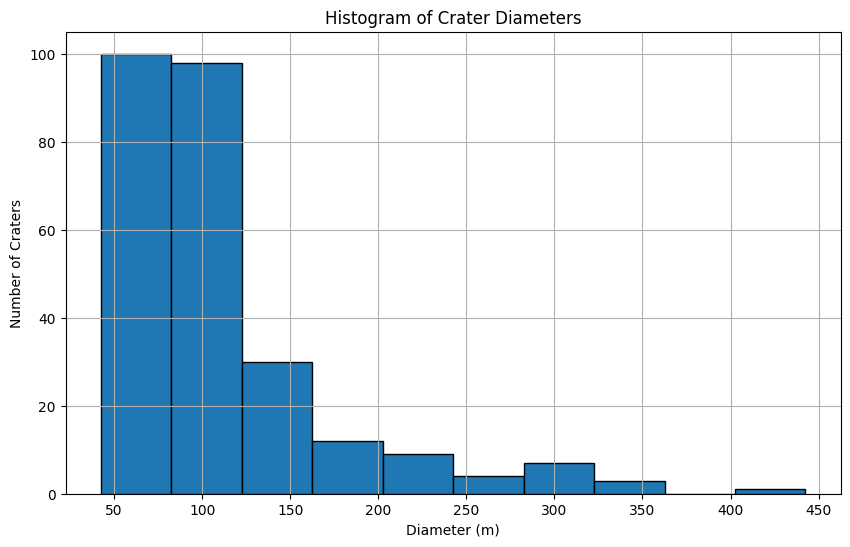

In [126]:
plt.figure(figsize=(10, 6))
plt.hist(crater_data['diameter in m'], bins=10, edgecolor='black')
plt.xlabel('Diameter (m)')
plt.ylabel('Number of Craters')
plt.title('Histogram of Crater Diameters')
plt.grid(True)
plt.show()

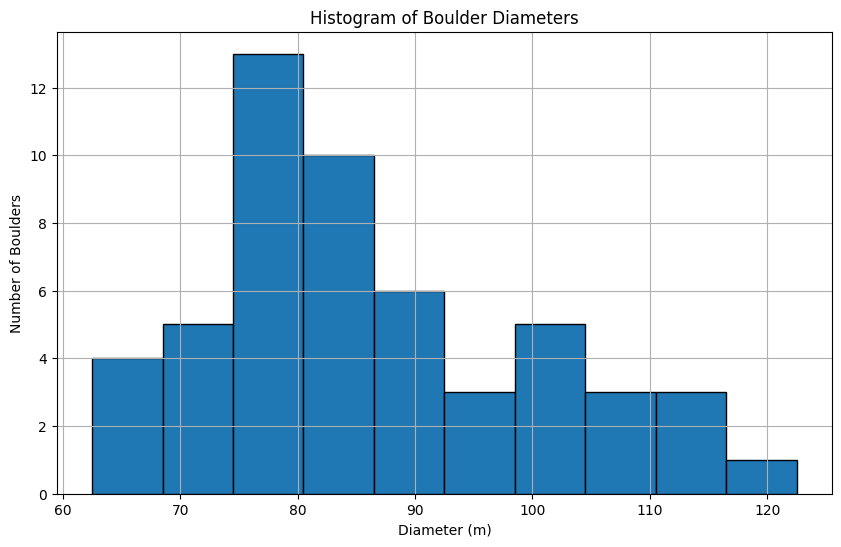

In [127]:
plt.figure(figsize=(10, 6))
plt.hist(boulder_data['diameter in m'], bins=10, edgecolor='black')
plt.xlabel('Diameter (m)')
plt.ylabel('Number of Boulders')
plt.title('Histogram of Boulder Diameters')
plt.grid(True)
plt.show()